In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.options import Options  


In [2]:
chrome_options = Options()  
chrome_options.add_argument("--headless")  
chrome_options.add_argument("--no-sandbox")

driver = webdriver.Chrome('chromedriver', options=chrome_options)

In [3]:
# url = 'https://bnonews.com/index.php/2020/02/the-latest-coronavirus-cases/'
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR30F8lYP3jG7YOq8es0PBpJIE5yvRVZffOyaqC0GgMBN6yt0Q-NI8pxS7hd1F9dYXnowSC6zpZmW9D/pubhtml'
driver.get(url)
content = driver.page_source


### Extract date time

In [4]:
# soup =BeautifulSoup(content, 'lxml')

In [5]:
# data = soup.findAll(text=re.compile("Last update: .+"))
# data

In [6]:
# m = re.search("Last update: (\d+ \w+ 202\d) at (\d+:\d+ [apAP].*[mM])", data[0])
# data_date_time = ' '.join([m.group(1), m.group(2)])
# data_date_time = re.sub("[\.]","",data_date_time)
# data_date_time = datetime.strptime(data_date_time, '%d %B %Y %I:%M %p').strftime('%Y-%m-%d %H:%M')
# data_date_time
data_date_time = datetime.now().strftime('%Y-%m-%d %H:%M')
data_date_time

'2020-03-07 02:11'

### Dataframes

In [7]:

dfs = pd.read_html(content)

In [8]:
len(dfs)
dfs[0]

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,1,Last update: 6 March 2020 at 8:28 p.m. ET,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,CASES,DEATHS,DEATHS,RECOVERED,RECOVERED,NaN,NaN,NaN
3,4,101907,3488,3488,57328,57328,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
95,96,Serbia,1,0,NaN,NaN,NaN,Source,NaN
96,97,Vatican City,1,0,NaN,NaN,NaN,Source,NaN
97,98,Colombia,1,0,NaN,NaN,NaN,Source,NaN
98,99,South Africa,1,0,NaN,NaN,NaN,Source,NaN


### International

In [9]:
df_intl=dfs[0]
df_intl  = df_intl.drop(df_intl .columns[0], axis=1)
df_intl  = df_intl.drop(list(range(6)), axis=0)
num_cols = len(df_intl.columns)
columns = ['d'] * num_cols
columns[0]='international'
columns[1]='cases'
df_intl.columns=columns
df_intl



,international,cases,d,d,d,d,d,d
6,Mainland China,80651,3070,5489,-,55404,Source,NaN
7,South Korea,6767,44,27,25,108,Source,NaN
8,Iran,4747,124,-,-,913,Source,NaN
9,Italy,4636,197,462,-,523,Source,NaN
10,Diamond Princess,696,6,34,-,40,Source,NaN
...,...,...,...,...,...,...,...,...
95,Serbia,1,0,NaN,NaN,NaN,Source,NaN
96,Vatican City,1,0,NaN,NaN,NaN,Source,NaN
97,Colombia,1,0,NaN,NaN,NaN,Source,NaN
98,South Africa,1,0,NaN,NaN,NaN,Source,NaN


In [10]:
df_intl.columns = df_intl.columns.map(str.lower)
df_intl = df_intl.dropna(0, how='all')

#### Cases

In [11]:
df_intl_cases = df_intl[['international', 'cases']].set_index('international').T
df_intl_cases = df_intl_cases.apply(lambda row: 
                   [re.sub('[^\d]+', '', x)  for x in row ])
df_intl_cases = df_intl_cases.apply(lambda row: 
                   [int(x) if x!='' else 0  for x in row ])

In [12]:
df_intl_cases = df_intl_cases.drop(['TOTAL'], axis=1)

In [13]:
# add date time column
df_intl_cases.insert(0, 'datetime', data_date_time)
try:
    df_intl_cases.drop('Mainland China', axis=1, inplace=True)
except Exception(e):
    pass
df_intl_cases

international,datetime,South Korea,Iran,Italy,Diamond Princess,Germany,France,Japan,United States,Spain,...,Andorra,Armenia,Dominican Republic,Liechtenstein,Bhutan,Gibraltar,Serbia,Vatican City,Colombia,South Africa
cases,2020-03-07 02:11,6767,4747,4636,696,670,613,350,321,374,...,1,1,1,1,1,1,1,1,1,1


In [14]:
# some assertion to ensure data quality
assert int(df_intl_cases['South Korea'])>6000

#### Save to file

In [15]:
from pathlib import Path
csv_file = 'data/bnonews-international.csv'

df = df_intl_cases

if Path(csv_file).exists():
    old_df = pd.read_csv(csv_file, parse_dates=True)

    df = pd.concat([old_df, df], sort=True)
df = df.set_index('datetime').fillna(0)

In [16]:

df = df.loc[~df.index.duplicated(keep='first')]
df.sort_values(by=['datetime'], inplace=True)


for col in df.columns:
    df[col] = df[col].astype('int')
    
df

,Afghanistan,Algeria,Andorra,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahrain,Belarus,...,Switzerland,Taiwan,Thailand,Tunisia,UAE,Ukraine,United Kingdom,United States,Vatican City,Vietnam
datetime,,,,,,,,,,,,,,,,,,,,,
2020-02-06 08:03,0,0,0,0,0,15,0,0,0,0,...,0,0,25,0,5,0,2,12,0,12
2020-02-06 08:19,0,0,0,0,0,15,0,0,0,0,...,0,0,25,0,5,0,3,12,0,12
2020-02-06 09:01,0,0,0,0,0,15,0,0,0,0,...,0,0,25,0,5,0,3,12,0,12
2020-02-06 09:46,0,0,0,0,0,15,0,0,0,0,...,0,0,25,0,5,0,3,12,0,12
2020-02-06 17:56,0,0,0,0,0,15,0,0,0,0,...,0,0,25,0,5,0,3,12,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-06 22:11,1,17,1,1,1,61,55,6,49,6,...,210,45,47,1,27,1,164,272,1,16
2020-03-06 23:11,1,17,1,1,1,61,55,6,49,6,...,210,45,47,1,27,1,164,309,1,16
2020-03-07 00:15,1,17,1,1,1,61,55,6,49,6,...,210,45,47,1,27,1,164,316,1,17


In [17]:

df.to_csv(csv_file, index=True)


Text(0.5, 0, 'Number of cases, sampled at 2020-03-07 02:11')

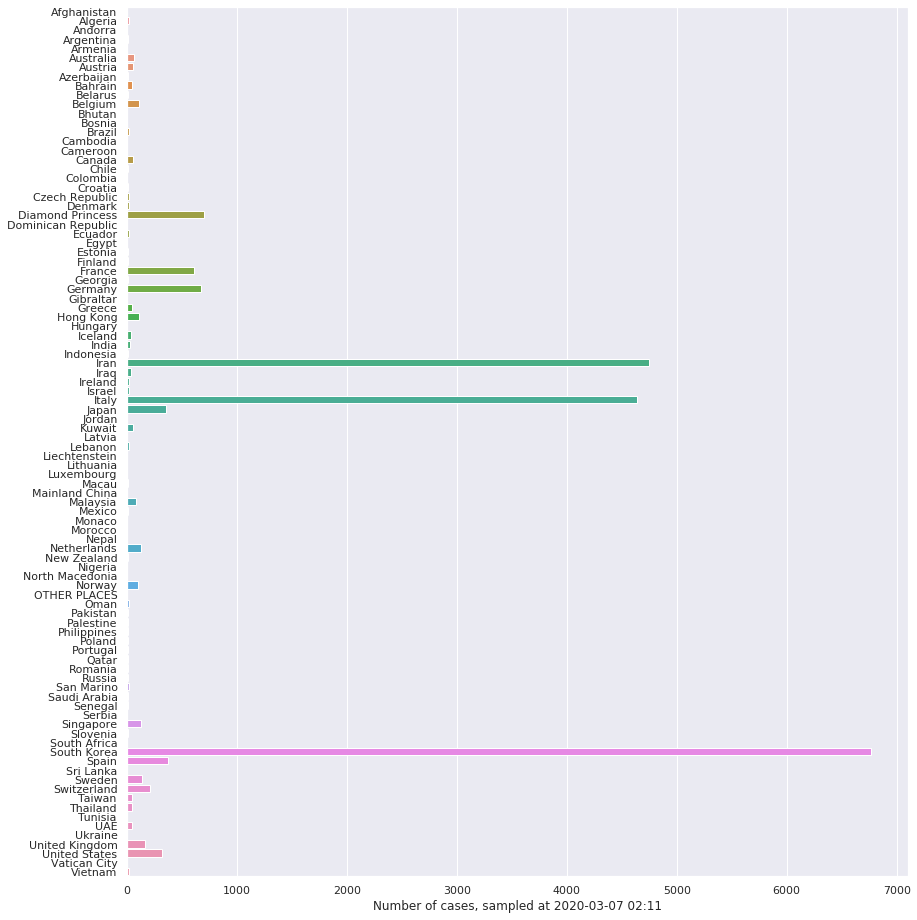

In [18]:
import seaborn as sns

series = df.iloc[-1]

sns.set(rc={'figure.figsize':(14,16)})
ax = sns.barplot(y=series.index, x=series)
ax.set_xlabel('Number of cases, sampled at '+series.name)



In [19]:
png_file='images/bnonews-international.png'
fig = ax.get_figure()
fig.savefig(png_file)